In [67]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [68]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel, model
import geopandas as gpd
if manual:
    %matplotlib inline

In [69]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'
plot_path = training_folder + 'outputs/plot/'

In [70]:
sm = stepmodel.read_zippedpickles(training_folder + 'model/{scen}/base'.format(scen=scenario))

zones: 100%|████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 111.68it/s]


In [71]:
sm.nodes.index = sm.nodes['stop_id']

# add road

In [72]:
road_links = gpd.read_file(input_folder+'road/road_links.geojson', driver='GeoJSON')
road_nodes = gpd.read_file(input_folder+'road/road_nodes.geojson', driver='GeoJSON')
road_nodes.set_index('index', inplace=True)
sm.road_links = road_links
sm.road_nodes = road_nodes

In [73]:
sm.road_links = sm.road_links.drop_duplicates('geometry')

# road integrity

In [74]:
sm.integrity_fix_collision()

can not add prefixes on table:  footpaths


## road_fix

In [75]:
sm.integrity_fix_road_network(cutoff=10, recursive_depth=5)

direct: 6254it [00:00, 11389.53it/s]
reversed: 6254it [00:00, 11863.18it/s]
5927it [00:00, 11284.14it/s]


## road_test

In [76]:
sm.integrity_test_dead_ends()

5927it [00:00, 28927.11it/s]


In [77]:
sm.integrity_fix_nodeset_consistency()

In [78]:
sm.integrity_test_isolated_roads()

# Transport Integrity

## transport_fix

In [79]:
sm.integrity_fix_collision()
sm.integrity_fix_circular_lines()
sm.integrity_fix_sequences()

dropped circular lines: ['100100105:105_1', '100100290:290_1', '100100191:191_2', '100100129:129_1', '100100059:59_2', '100100323:323_1', '100100249:249_1']


## transport_test

In [80]:
sm.integrity_fix_nodeset_consistency()

In [81]:
sm.integrity_test_circular_lines()
sm.integrity_test_collision()
sm.integrity_test_nodeset_consistency()
sm.integrity_test_sequences()

In [82]:
sm.integrity_test_all(errors='raise')

passed: integrity_test_circular_lines
passed: integrity_test_collision


5927it [00:00, 34653.33it/s]


passed: integrity_test_dead_ends
passed: integrity_test_isolated_roads
passed: integrity_test_nodeset_consistency


5927it [00:00, 11357.83it/s]


passed: integrity_test_road_network
passed: integrity_test_road_nodeset_consistency
passed: integrity_test_sequences


In [83]:
sm = sm.change_epsg(epsg=3857, coordinates_unit='meter')

Reprojecting model from epsg 4326 to epsg 3857: 100%|██████████████████████████████████| 17/17 [00:00<00:00, 17.94it/s]


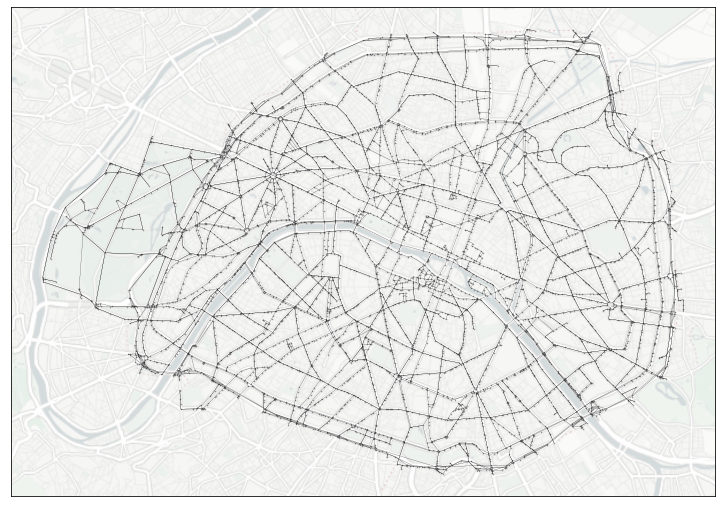

In [84]:
if manual:
    sm.plot(
        'road_nodes', color='grey', markersize=0.2,
        ax=sm.plot(
            'road_links', figsize=[16, 9], 
            basemap_url= 'http://a.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}.png', linewidth=0.2, color='black'
        ),    
    )

# to_zip

In [85]:
sm.to_zippedpickles(training_folder + 'model/{scen}/networks'.format(scen=scenario))

orphan_nodes: 100%|████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 26.53it/s]


# END